In [105]:
import pandas as pd

random_state = 42
training_df = pd.read_csv('data/pulsar_data_train.csv')

print(f'{training_df.dtypes=}')

training_df.head()


training_df.dtypes= Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [106]:

def remove_nan(df: pd.DataFrame) -> pd.DataFrame:

    mask = df.isna().any()
    cols_with_nan = df.columns[mask]
    df[cols_with_nan] = df[cols_with_nan].fillna(0)
    return df


Y = training_df['target_class']
X = training_df.loc[:, training_df.columns != 'target_class']

X = remove_nan(X)



/var/folders/bh/79ms89214n70lb56qjzk005c0000gn/T/ipykernel_3173/1037121549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_with_nan] = df[cols_with_nan].fillna(0)


In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

scaler = StandardScaler()

X[:] = scaler.fit_transform(X[:])



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

X_train = torch.from_numpy(X_train.to_numpy()).to(torch.float32)
X_test = torch.from_numpy(X_test.to_numpy()).to(torch.float32)

Y_train = torch.from_numpy(Y_train.to_numpy()).to(torch.float32)
Y_test = torch.from_numpy(Y_test.to_numpy()).to(torch.float32)

Y_train = Y_train.view(Y_train.shape[0], -1)
Y_test = Y_test.view(Y_test.shape[0], -1)



/var/folders/bh/79ms89214n70lb56qjzk005c0000gn/T/ipykernel_3173/444623445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[:] = scaler.fit_transform(X[:])


In [178]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        
        self.fc1 = nn.Linear(num_units, num_units)
        self.fc2 = nn.Linear(num_units, num_units)
        self.fc3 = nn.Linear(num_units, num_units)
        self.fc4 = nn.Linear(num_units, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))

        return x


class MLP_Regularized(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        
        self.fc1 = nn.Linear(num_units, num_units)
        self.drop1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(num_units, num_units)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(num_units, num_units)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(num_units, 1)
        self.drop4 = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = F.relu(self.drop3(self.fc3(x)))
        x = F.sigmoid(self.drop4(self.fc4(x)))

        return x


In [109]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

num_epochs = 100
critereon = nn.BCELoss

classifier = NeuralNetClassifier(
    MLP,
    max_epochs=num_epochs,
    criterion=critereon,
    train_split=None,
    verbose=0
)

params = {
    'lr': [0.01, 0.001],
    'batch_size': [10, 25],
    'module__num_units': [8, 16],
    'optimizer': [torch.optim.Adam, torch.optim.SGD]
}



grid = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', n_jobs=-1, cv=3)
grid.fit(X_train, Y_train)

# Print the results
print(f'{grid.best_params_=}')
print(f'{grid.best_score_=}')




/Users/alejandro/Programming/Courses/EEC189G-Spring23/HW3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alejandro/Programming/Courses/EEC189G-Spring23/HW3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alejandro/Programming/Courses/EEC189G-Spring23/HW3/.venv/lib/python3.11/site-packages/skorch/classifier.py", line 143, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  

grid.best_params_={'batch_size': 25, 'lr': 0.01, 'module__num_units': 8, 'optimizer': <class 'torch.optim.adam.Adam'>}
grid.best_score_=0.9778487920895712


In [179]:
from torch.utils.data import TensorDataset, DataLoader

# Combine the two tensors into a dataset

val_index = int(len(X_train) * 0.8)

dataset = TensorDataset(X_train[:val_index, ], Y_train[:val_index, ])
val_data = (X_train[val_index:, ], Y_train[val_index:, ])

dataloader = DataLoader(dataset, batch_size=grid.best_params_['batch_size'])

model = MLP_Regularized(grid.best_params_['module__num_units'])
optimizer = grid.best_params_['optimizer'](model.parameters(), lr=grid.best_params_['lr'])

train_loss: list[float] = []
train_acc: list[float] = []
val_loss: list[float] = []
val_acc: list[float] = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = critereon()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += labels.size(0)

        predicted = (outputs > 0.5).float()

        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(dataloader))
    train_acc.append(correct / total)

    with torch.no_grad():
        model.eval()
        val_inputs, val_labels = val_data
        val_outputs = model(val_inputs)
        loss = critereon()(val_outputs, val_labels)
        val_loss.append(loss.item())
        val_total = val_labels.size(0)

        val_predicted = (val_outputs > 0.5).float()
        val_correct = (val_predicted == val_labels).sum().item()
        val_acc.append(val_correct / val_total)
        model.train()

    print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader):.3f} train_acc: {(correct / total):.3f} val_acc: {(val_correct / val_total):.3f}')


Epoch 1 loss: 0.187 train_acc: 0.945 val_acc: 0.978
Epoch 2 loss: 0.161 train_acc: 0.965 val_acc: 0.976
Epoch 3 loss: 0.158 train_acc: 0.970 val_acc: 0.978
Epoch 4 loss: 0.148 train_acc: 0.972 val_acc: 0.980
Epoch 5 loss: 0.154 train_acc: 0.970 val_acc: 0.979
Epoch 6 loss: 0.159 train_acc: 0.970 val_acc: 0.978
Epoch 7 loss: 0.154 train_acc: 0.970 val_acc: 0.980
Epoch 8 loss: 0.150 train_acc: 0.969 val_acc: 0.976
Epoch 9 loss: 0.156 train_acc: 0.970 val_acc: 0.980
Epoch 10 loss: 0.150 train_acc: 0.968 val_acc: 0.980
Epoch 11 loss: 0.152 train_acc: 0.968 val_acc: 0.979
Epoch 12 loss: 0.150 train_acc: 0.970 val_acc: 0.979
Epoch 13 loss: 0.150 train_acc: 0.970 val_acc: 0.979
Epoch 14 loss: 0.147 train_acc: 0.969 val_acc: 0.977
Epoch 15 loss: 0.147 train_acc: 0.968 val_acc: 0.978
Epoch 16 loss: 0.148 train_acc: 0.969 val_acc: 0.978
Epoch 17 loss: 0.155 train_acc: 0.968 val_acc: 0.980
Epoch 18 loss: 0.154 train_acc: 0.967 val_acc: 0.979
Epoch 19 loss: 0.144 train_acc: 0.973 val_acc: 0.981
Ep

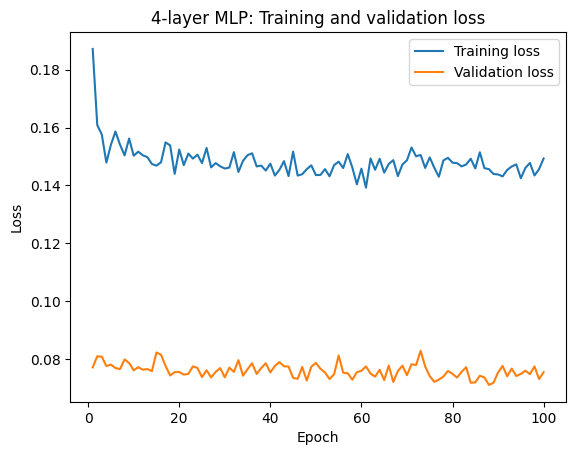

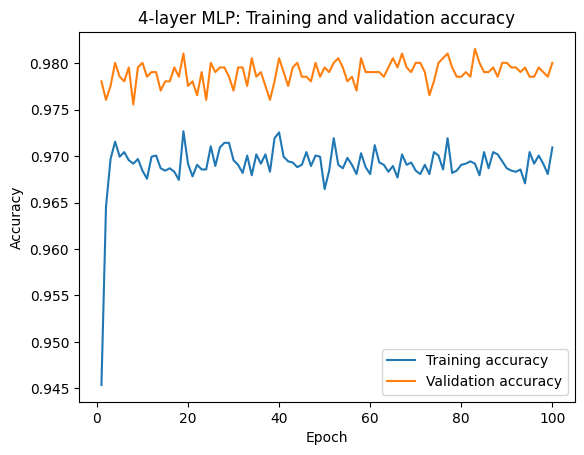

In [182]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('4-layer MLP: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('4-layer MLP: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

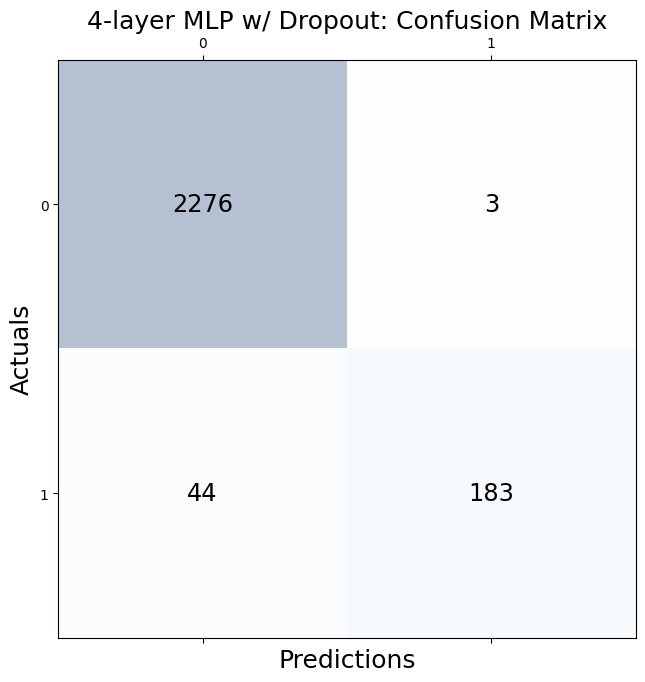

test_accuracy=0.981
test_f1=0.886
test_recall=0.806
test_precision=0.984
test_loss=0.074


In [181]:
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix, BinaryF1Score, BinaryRecall, BinaryPrecision

acc_metric = BinaryAccuracy()
bcm_metric = BinaryConfusionMatrix()
f1_metric = BinaryF1Score()
recall_metric = BinaryRecall()
precision_metric = BinaryPrecision()

with torch.no_grad():
    model.eval()
    val_outputs = model(X_test)
    test_loss = critereon()(val_outputs, Y_test).item()
    test_total = Y_test.size(0)

    test_predicted = (val_outputs > 0.5).float()
    test_accuracy = acc_metric(test_predicted, Y_test).item()
    test_bcm = bcm_metric(test_predicted, Y_test)
    test_f1 = f1_metric(test_predicted, Y_test).item()
    test_recall = recall_metric(test_predicted, Y_test).item()
    test_precision = precision_metric(test_predicted, Y_test).item()


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(test_bcm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(test_bcm.shape[0]):
    for j in range(test_bcm.shape[1]):
        ax.text(x=j, y=i,s=test_bcm[i, j].item(), va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('4-layer MLP: Confusion Matrix', fontsize=18)
plt.show()

print(f'{test_accuracy=:.3f}')
print(f'{test_f1=:.3f}')
print(f'{test_recall=:.3f}')
print(f'{test_precision=:.3f}')
print(f'{test_loss=:.3f}')